# Solution : Prédiction de la meilleure distance obtenue avec le club de golf bois 3

In [372]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 99

golf = pd.read_csv('golf-data.csv')

golf.head(20)

,Portee,Distance Totale,Club,Vitesse de balle,Apex,Angle envol,Dispersion,Distance au drapeau
0,188,205,3,131,26,"14,8","5,3","8,4"
1,176,186,3,126,37,"20,7","37,6","47,4"
2,193,208,3,134,31,"16,7","25,7","30,1"
3,193,211,3,132,26,"14,8","7,4","9,2"
4,183,194,3,127,34,"19,3","10,9","16,9"
5,201,223,3,138,22,"12,1","2,4","18,9"
6,194,210,3,133,30,"16,8","18,1","22,1"
7,184,197,3,132,30,"16,6","29,2","35,7"
8,191,208,3,130,29,"17,1","12,6","15,2"
9,202,220,3,138,27,"13,3","17,8","24,5"


In [373]:
stripped_commas_a = golf["Angle envol"].str.replace(",",".")
golf["Angle envol"] = stripped_commas_a.astype('float')

stripped_commas_d = golf["Dispersion"].str.replace(",",".")
golf["Dispersion"] = stripped_commas_d.astype('float')

stripped_commas_dd = golf["Distance au drapeau"].str.replace(",",".")
golf["Distance au drapeau"] = stripped_commas_dd.astype('float')

#numéro du club de golf
club_golf_number = 3

filter_club=golf["Club"]==club_golf_number
golf.where(filter_club, inplace = True)
golf.dropna(subset=['Portee'], inplace = True)
del golf["Club"]
del golf["Distance Totale"]

golf.head(20)

,Portee,Vitesse de balle,Apex,Angle envol,Dispersion,Distance au drapeau
0,188.0,131.0,26.0,14.8,5.3,8.4
1,176.0,126.0,37.0,20.7,37.6,47.4
2,193.0,134.0,31.0,16.7,25.7,30.1
3,193.0,132.0,26.0,14.8,7.4,9.2
4,183.0,127.0,34.0,19.3,10.9,16.9
5,201.0,138.0,22.0,12.1,2.4,18.9
6,194.0,133.0,30.0,16.8,18.1,22.1
7,184.0,132.0,30.0,16.6,29.2,35.7
8,191.0,130.0,29.0,17.1,12.6,15.2
9,202.0,138.0,27.0,13.3,17.8,24.5


In [374]:
# Normaliser toutes les colonnes de sorte que les valeurs soient comprises entre 0 et 1 sauf pour la colonne cible.
portee_col = golf['Portee']
golf = (golf - golf.min())/(golf.max() - golf.min())
golf['Portee'] = portee_col

golf.head(20)

,Portee,Vitesse de balle,Apex,Angle envol,Dispersion,Distance au drapeau
0,188.0,0.416667,0.266667,0.313953,0.082386,0.000000
1,176.0,0.000000,1.000000,1.000000,1.000000,1.000000
2,193.0,0.666667,0.600000,0.534884,0.661932,0.556410
3,193.0,0.500000,0.266667,0.313953,0.142045,0.020513
4,183.0,0.083333,0.800000,0.837209,0.241477,0.217949
5,201.0,1.000000,0.000000,0.000000,0.000000,0.269231
6,194.0,0.583333,0.533333,0.546512,0.446023,0.351282
7,184.0,0.500000,0.533333,0.523256,0.761364,0.700000
8,191.0,0.333333,0.466667,0.581395,0.289773,0.174359
9,202.0,1.000000,0.333333,0.139535,0.437500,0.412821


## Modèle univarié

In [375]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(k, train_col, target_col, df):
    knn = KNeighborsRegressor(n_neighbors=k)
    np.random.seed(0)
    
    # Randomiser l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)

    
    # Sélectionner la première moitié en set de training.
    # Sélectionner la seconde moitié en set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    #print(train_df)
    #print("-------------------")
    #print(test_df)

    # Ajuster un modèle KNN utilisant la valeur par défaut k.
    knn.fit(train_df[[train_col]], train_df[target_col])

    # faire des prédictions en utilisant ce modèle.
    predicted_labels = knn.predict(test_df[[train_col]])
    
    # Calculer et retourner la valeur RMSE.
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    
    return rmse

In [397]:
rmse_results = {}
train_cols = golf.columns.drop('Portee')

#train_cols.head()
# Pour chaque colonne (excepté 'Portee'), entrainer un modèle et retourner la valeur RMSE.
# et ajouter cette valeur au dictionnaire 'rmse_results'.
k = 3

for col in train_cols:
    rmse_val = knn_train_test(k ,col, 'Portee', golf)
    rmse_results[col] = rmse_val

# Créer un objet Series depuis le dictionnaire
# ainsi nous pouvons facilement voir les résultats, les trier, etc…
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

Vitesse de balle       3.895867
Angle envol            5.316641
Dispersion             5.331250
Distance au drapeau    5.331250
Apex                   6.656659
dtype: float64

In [377]:
def knn_train_test2(train_col, target_col, df):
    np.random.seed(0)
    
    # Randomiser l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)

    # Sélectionner la première moitié en set de training.
    # Sélectionner la seconde moitié en set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,2,3]
    k_rmses = {}
    
    for k in k_values:
        # Ajuster un modèle KNN utilisant la valeur de k en paramètre.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])
        
        # faire des prédictions en utilisant ce modèle.
        predicted_labels = knn.predict(test_df[[train_col]])
        
        # Calculer et retourner la valeur RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

In [378]:
feature_k_rmse_results = {}

# Pour chaque colonne (excepté 'Portee'), entrainer un modèle et retourner la valeur RMSE.
# et ajouter cette valeur au dictionnaire 'rmse_results'.
train_cols = golf.columns.drop('Portee')
for col in train_cols:
    rmse_val = knn_train_test2(col, 'Portee', golf)
    feature_k_rmse_results[col] = rmse_val
    
feature_k_rmse_results

{'Vitesse de balle': {1: 4.2895221179054435,
  2: 4.410215414239989,
  3: 3.895866755649859},
 'Apex': {1: 8.48528137423857, 2: 5.8779248038742375, 3: 6.656659155395533},
 'Angle envol': {1: 8.48528137423857,
  2: 6.176568626672903,
  3: 5.316640543300504},
 'Dispersion': {1: 10.89954127475097,
  2: 6.920982589199311,
  3: 5.331249592939937},
 'Distance au drapeau': {1: 9.818350166906862,
  2: 9.137833441248533,
  3: 5.331249592939937}}

Vitesse de balle
average_rmse: 4.19853476259843
Apex
average_rmse: 7.006621777836114
Angle envol
average_rmse: 6.659496848070659
Dispersion
average_rmse: 7.7172578189634065
Distance au drapeau
average_rmse: 8.095811067031777


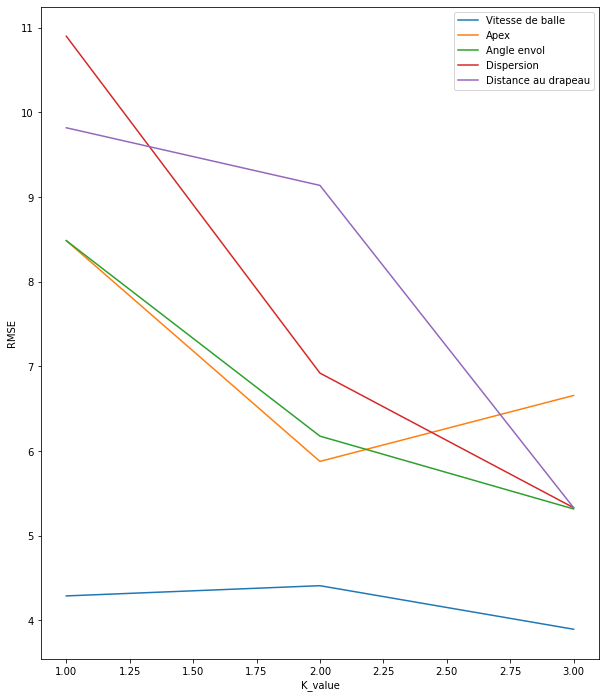

In [379]:
import matplotlib.pyplot as plt
%matplotlib inline

best_features = {}
plt.figure(figsize=(10, 12))

for key, value in feature_k_rmse_results.items():
    x = list(value.keys())
    y = list(value.values())
    
    order = np.argsort(x)
    x_ordered = np.array(x)[order]
    y_ordered = np.array(y)[order]
    print(key)
    print('average_rmse: '+str(np.mean(y)))
    best_features[key] = np.mean(y)

    plt.plot(x_ordered, y_ordered, label=key)
    plt.xlabel("K_value")
    plt.ylabel("RMSE")
plt.legend()
plt.show()

In [380]:
sorted_features_list = sorted(best_features, key=best_features.get)
sorted_features_list

['Vitesse de balle',
 'Angle envol',
 'Apex',
 'Dispersion',
 'Distance au drapeau']

## Modèle multivarié

In [381]:
def knn_train_test3(train_cols, target_col, df):
    np.random.seed(0)
    
    # Randomise l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)
    
    # Sélectionner la première moitié pour le set de training.
    # Sélectionner la seconde moitié pour le set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [3]
    k_rmses = {}
    
    for k in k_values:
        # Ajuster le modèle en utilisant la valeur k.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])
        
        # Faire des prédictions en utilisant le modèle.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculer et retourner la valeur RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
        
    return k_rmses

In [382]:
k_rmse_features ={}

best_two_features = sorted_features_list[0:2]
best_three_features = sorted_features_list[0:3]
best_four_features = sorted_features_list[0:4]

k_rmse_features["best_two_rmse"]  = knn_train_test3(best_two_features, 'Portee', golf)
k_rmse_features["best_three_rmse"] = knn_train_test3(best_three_features, 'Portee', golf)
k_rmse_features["best_four_rmse"] = knn_train_test3(best_four_features, 'Portee', golf)

k_rmse_features

{'best_two_rmse': {3: 5.316640543300504},
 'best_three_rmse': {3: 4.860269768461648},
 'best_four_rmse': {3: 6.656659155395533}}

## Variation des hyper paramètres

In [383]:
def knn_train_test4(train_cols, target_col, df):
    np.random.seed(0)
    
    # Randomise l'ordre des lignes du DataFrame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # Diviser le nombre de lignes de moitié.
    last_train_row = int(len(rand_df) / 2)
    
    # Sélectionner la première moitié pour le set de training.
    # Sélectionner la seconde moitié pour le set de test.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 3)]
    k_rmses = {}
    
    for k in k_values:
        # Ajuster le modèle en utilisant la valeur k.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])
        
        # Faire des prédictions en utilisant le modèle.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculer et retourner la valeur RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
        
    return k_rmses

In [384]:
features = [best_two_features, best_three_features]
k_rmse_results = {}
k_rmse_results["best_two_features"] = knn_train_test4(best_two_features, 'Portee', golf)
k_rmse_results["best_three_features"] = knn_train_test4(best_three_features, 'Portee', golf)

k_rmse_results

{'best_two_features': {1: 4.2895221179054435, 2: 4.410215414239989},
 'best_three_features': {1: 4.381780460041329, 2: 4.410215414239989}}

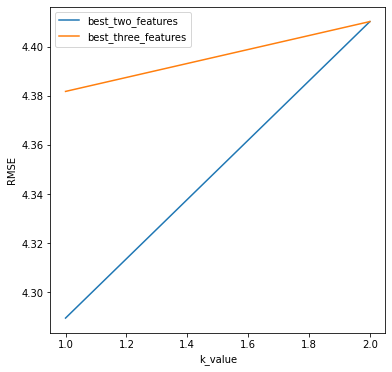

In [385]:
plt.figure(figsize=(6, 6))

for key, value in k_rmse_results.items():
    
    x = list(value.keys())
    y = list(value.values())
    plt.plot(x, y, label=key)
    plt.xlabel("k_value")
    plt.ylabel("RMSE")
    
plt.legend()
plt.show()